In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
!pip install -q keras
from keras.utils import to_categorical
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns




drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#train+, test+ and test21- dataset loading
train='/content/drive/My Drive/Datasets/NSL-KDD/nsl-kdd/KDDTrain+.txt'
test='/content/drive/My Drive/Datasets/NSL-KDD/nsl-kdd/KDDTest+.txt'
test21='/content/drive/My Drive/Datasets/NSL-KDD/nsl-kdd/KDDTest-21.txt'

featureV=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

flagV=['OTH','RSTOS0','SF','SH','RSTO','S2','S1','REJ','S3','RSTR','S0']

protocol_typeV=['tcp','udp','icmp']

serviceV=['http','smtp','finger','domain_u','auth','telnet','ftp','eco_i','ntp_u','ecr_i','other','private','pop_3','ftp_data',
                  'rje','time','mtp','link','remote_job','gopher','ssh','name','whois','domain','login','imap4','daytime','ctf','nntp',
                  'shell','IRC','nnsp','http_443','exec','printer','efs','courier','uucp','klogin','kshell','echo','discard','systat',
                  'supdup','iso_tsap','hostnames','csnet_ns','pop_2','sunrpc','uucp_path','netbios_ns','netbios_ssn','netbios_dgm',
                  'sql_net','vmnet','bgp','Z39_50','ldap','netstat','urh_i','X11','urp_i','pm_dump','tftp_u','tim_i','red_i','icmp',
                  'http_2784','harvest','aol','http_8001']

binary_attack=['normal','ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan','back', 'land', 'neptune', 'pod', 'smurf',
               'teardrop', 'apache2', 'udpstorm', 'processtable','mailbomb','buffer_overflow', 'loadmodule', 'perl', 'rootkit',
               'xterm', 'ps', 'sqlattack','ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy', 'warezclient',
               'warezmaster','snmpgetattack','named', 'xlock', 'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']

multiclass_attack={ 'normal': 'normal',
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'],
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'],
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'],
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.',
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}                   

In [ ]:
train_data=pd.read_csv(train,names=featureV)
test_data=pd.read_csv(test,names=featureV)

In [ ]:
test_21 = pd.read_csv(test21, names= featureV)

In [ ]:
train_data = train_data.query("service != 'aol'")
train_data = train_data.query("service != 'harvest'")
train_data = train_data.query("service != 'http_2784'")
train_data = train_data.query("service != 'http_8001'")
train_data = train_data.query("service != 'red_i'")
train_data = train_data.query("service != 'urh_i'")
train_data = train_data.query("service != 'printer'")
train_data = train_data.query("service != 'rje'")


#-------------------------------------------------------------------------------->>>>

test_data = test_data.query("service != 'printer'")
test_data = test_data.query("service != 'rje'")

# Working with **Training** Data 

In [ ]:
def bar_graph(feature):
    train_data[feature].value_counts().plot(kind="bar")

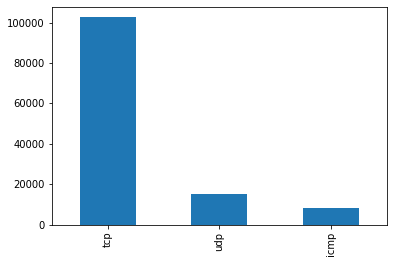

In [ ]:
bar_graph('protocol_type')

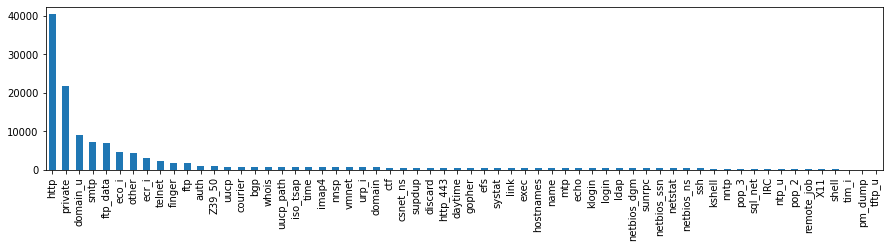

In [ ]:
plt.figure(figsize=(15,3))
bar_graph('service')

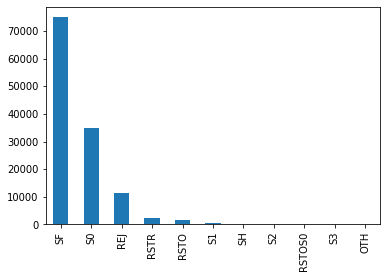

In [ ]:
bar_graph('flag')

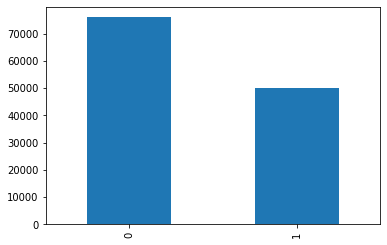

In [ ]:
bar_graph('logged_in')

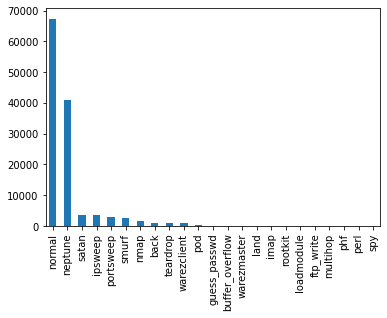

In [ ]:
bar_graph('label')

# **Correlations**

# Working with **Validation** data

In [ ]:
def preprocessing(data,cls,df):
  
#----------attack categorization----------------->
  data['label']=data['label'].replace(['normal.','normal'],0)

#----------------------binary classification--------------------->
  if cls=='binary':
    for i in range(len(binary_attack)):
      data['label'] = data['label'].replace(binary_attack[i], 1)
  
#---------------multiclass classification-------------------->  
  elif cls=='multiclass':
    for i in range(len(multiclass_attack['probe'])):
      data['label']=data['label'].replace([multiclass_attack['probe'][i],multiclass_attack['probe'][i][:-1]],1)
    
    for i in range(len(multiclass_attack['dos'])):
      data['label']=data['label'].replace([multiclass_attack['dos'][i],multiclass_attack['dos'][i][:-1]],2)
    
    for i in range(len(multiclass_attack['u2r'])):
      data['label']=data['label'].replace([multiclass_attack['u2r'][i],multiclass_attack['u2r'][i][:-1]],3)
    
    for i in range(len(multiclass_attack['r2l'])):
      data['label'] = data['label'].replace([multiclass_attack['r2l'][i],multiclass_attack['r2l'][i][:-1]],4)
#------------------------------------------------>


#-------------------------splitting features and labels---------------->
  y=data['label']
  x=data.loc[:,'duration':'hot']
#---------------------------------------------------------------------->


#-----------------------------------converting string objects to int------------------------>
  #for i in range(len(protocol_typeV)):
   # x['protocol_type'] = x['protocol_type'].replace(protocol_typeV[i], i)
  
  #for i in range(len(serviceV)):
   # x['service'] = x['service'].replace(serviceV[i], i+1)

  #for i in range(len(flagV)):
   # x['flag'] = x['flag'].replace(flagV[i], i+1)
#------------------------------------------------------------------------------------------->

#-----------------converting to binary feature vectors-------------------------------------->  
  t=x.protocol_type.copy()
  t=pd.get_dummies(t)
  x=x.drop(columns='protocol_type',axis=1)
  x=x.join(t)

  t1=x.service.copy()
  t1=pd.get_dummies(t1)
  x=x.drop(columns='service',axis=1)
  x=x.join(t1)

  t2=x.flag.copy()
  t2=pd.get_dummies(t2)
  x=x.drop(columns='flag',axis=1)
  x=x.join(t2)
#------------------------------------------------------------------------------>

#-----------------converting to binary label vectors--------------------------------------> 
  yt=y.copy()
  yt=pd.get_dummies(yt)
#------------------------------------------------------------------------------>

  x = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)
  # x = MaxAbsScaler().fit_transform(x)
  # x = StandardScaler().fit_transform(x)
  #print(x)
  #vectorizer = CountVectorizer()
  #p= vectorizer.fit_transform(x.protocol_type)

  #print(np.shape(p))
  #scaler = Normalizer(norm='l1').fit(x)
  #trainX = scaler.transform(x)
  if df=='train':
    return x,yt
  else:
    return x,y  

In [ ]:
x_train,Y_train=preprocessing(train_data,cls='binary',df='train')
x_test,Y_test=preprocessing(test_data,cls='binary',df='test')

In [ ]:
x_21_test, y_21_test = preprocessing(test_21, cls = 'binary', df = 'test21')

In [ ]:
print(np.shape(x_train))
print(np.shape(Y_train))
print(np.shape(x_test))
print(np.shape(Y_test))
print(np.shape(x_21_test))
print(np.shape(y_21_test))

(125793, 83)
(125793, 2)
(22525, 83)
(22525,)
(11850, 83)
(11850,)


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(125793, 83, 1)

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(22525, 83, 1)

In [ ]:
x_21_test = np.reshape(x_21_test, (x_21_test.shape[0], x_21_test.shape[1], 1))
x_21_test.shape


(11850, 83, 1)

# Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN , GRU , Activation
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import tensorflow as tf
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D , AveragePooling1D

In [ ]:
model = Sequential()

model.add(Convolution1D(32, 3, padding="same",activation="relu",input_shape = (x_train.shape[1], 1)))
# model.add(Convolution1D(32, 3, activation="relu"))
model.add(MaxPooling1D(pool_size=(4)))
# model.add(tf.keras.layers.LayerNormalization())
# model.add(GRU(units = 128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.5))

model.add(Convolution1D(64, 3, padding="same",activation="relu"))
# model.add(Convolution1D(64, 3,activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))
# model.add(tf.keras.layers.LayerNormalization())

# model.add(Convolution1D(64, 3, padding="same",activation="relu"))
# model.add(Convolution1D(64, 3,activation="relu"))
# model.add(AveragePooling1D(pool_size=(2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [ ]:
# tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# train_op = tf.keras.optimizers.adam(amsgrad=True)
model.compile(optimizer ='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(x_train, Y_train, epochs = 100, batch_size = 128)

Epoch 1/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1786 - accuracy: 0.9414
Epoch 2/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1499 - accuracy: 0.9525
Epoch 3/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1452 - accuracy: 0.9537
Epoch 4/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1422 - accuracy: 0.9548
Epoch 5/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1398 - accuracy: 0.9552
Epoch 6/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1376 - accuracy: 0.9554
Epoch 7/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1356 - accuracy: 0.9557
Epoch 8/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1344 - accuracy: 0.9558
Epoch 9/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1334 - accuracy: 0.9560
Epoch 10/100
983/983 [==============================] - 5s 6ms/step - loss: 0.1329 - accura

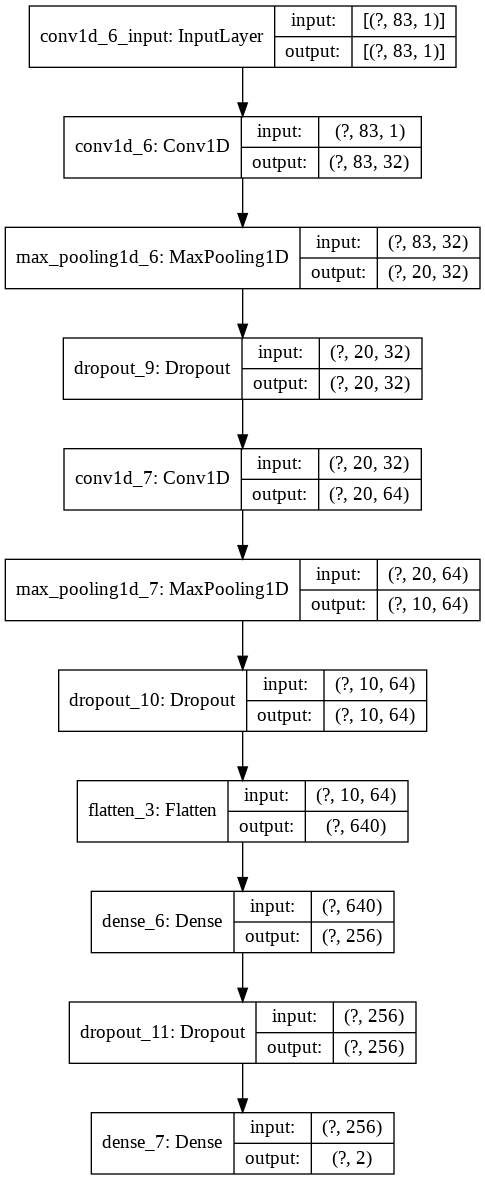

In [ ]:
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [ ]:
pred = model.predict(x_test)
y_pred= np.argmax(pred, axis = 1)

Evaluation of the model

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

In [ ]:
confusion_matrix(Y_test, y_pred)

array([[ 8721,   990],
       [ 2576, 10238]])

In [ ]:
accuracy =accuracy_score(Y_test, y_pred)*100
print(accuracy)

84.16870144284128


In [ ]:
print(y_pred)
# print(len(y_pred))

[1 1 0 ... 1 0 1]


In [ ]:
print(y_21_test)

0        1
1        1
2        1
3        0
4        1
        ..
11845    0
11846    0
11847    1
11848    1
11849    1
Name: label, Length: 11850, dtype: int64


In [ ]:
pred = model.predict(x_21_test)
y_pred= np.argmax(pred, axis = 1)

In [ ]:
confusion_matrix(y_21_test, y_pred)

array([[1204,  948],
       [2576, 7122]])

In [ ]:
print(y_pred)

[0 1 1 ... 1 1 1]


In [ ]:
acc_21 = accuracy_score(y_21_test, y_pred)* 100
print(acc_21)

70.26160337552743


In [ ]:
recall = recall_score(y_21_test, y_pred , average="binary")
precision = precision_score(y_21_test, y_pred , average="binary")
f1 = f1_score(y_21_test, y_pred, average="binary")

In [ ]:
  print("accuracy")
  print("%.3f" %acc_21)
  print("racall")
  print("%.3f" %recall)
  print("precision")
  print("%.3f" %precision)
  print("f1score")
  print(f1)

accuracy
70.262
racall
0.734
precision
0.883
f1score
0.8016659162539397


In [ ]:
print("F-Score : ", f1*100)
print("Precision : " , precision*100)
print("Recall : ", recall*100)
print("Accuracy : ",acc_21)

F-Score :  80.16659162539396
Precision :  88.25278810408922
Recall :  73.43782223138791
Accuracy :  70.26160337552743
